In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV



In [2]:
data = pd.read_csv('../cleaned_data.csv')
data.head()

,Age,Gender,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Workout_Type,Fat_Percentage,Water_Intake (liters),Workout_Frequency (days/week),Experience_Level,BMI
0,34.0,Female,86.7,1.86,174.0,152.0,74.0,1.12,712.0,Strength,12.8,2.4,5.0,2.0,14.31
1,26.0,Female,84.7,1.83,166.0,156.0,73.0,1.00,833.0,Strength,27.9,2.8,5.0,2.0,33.49
2,22.0,Male,64.8,1.85,187.0,166.0,64.0,1.24,1678.0,Cardio,28.7,1.9,3.0,2.0,12.73
3,54.0,Female,75.3,1.82,187.0,169.0,58.0,1.45,628.0,Cardio,31.8,2.4,4.0,1.0,20.37
4,34.0,Female,52.8,1.74,177.0,169.0,66.0,1.60,1286.0,Strength,26.4,3.2,4.0,2.0,20.83


In [3]:
data.dtypes


Age                              float64
Gender                            object
Weight (kg)                      float64
Height (m)                       float64
Max_BPM                          float64
Avg_BPM                          float64
Resting_BPM                      float64
Session_Duration (hours)         float64
Calories_Burned                  float64
Workout_Type                      object
Fat_Percentage                   float64
Water_Intake (liters)            float64
Workout_Frequency (days/week)    float64
Experience_Level                 float64
BMI                              float64
dtype: object

In [4]:
le = LabelEncoder()
data['Gender'] = le.fit_transform(data['Gender'])
data['Workout_Type'] = le.fit_transform(data['Workout_Type'])


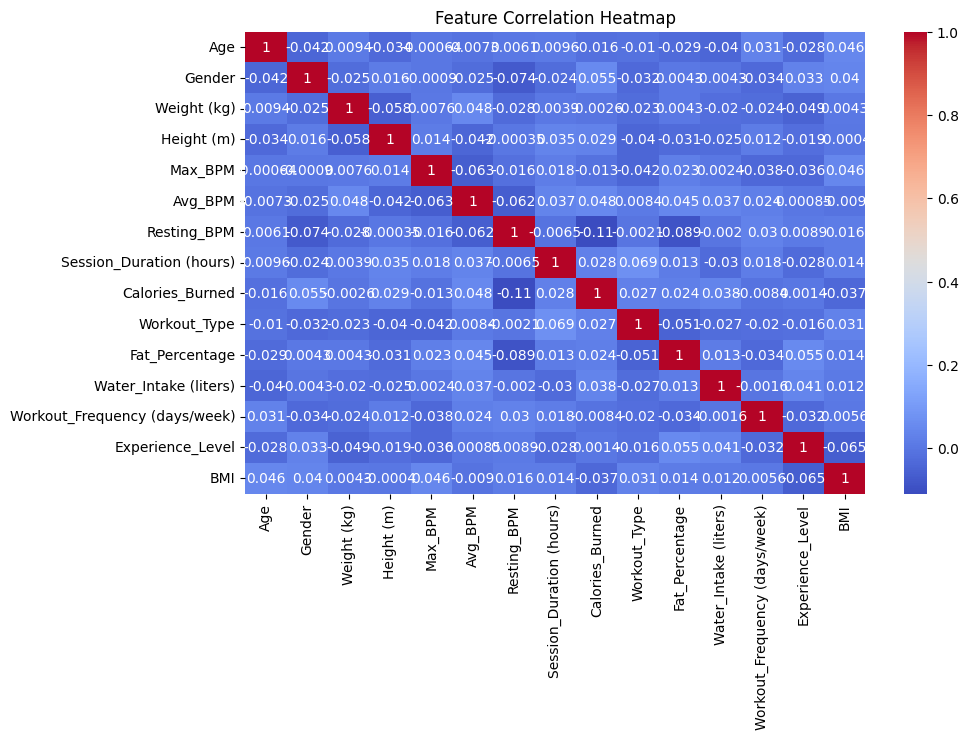

In [5]:
plt.figure(figsize=(10, 6))
sns.heatmap(data.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()


In [6]:
# features = ['Age', 'Weight (kg)', 'Height (m)', 'Avg_BPM', 'Max_BPM',
#             'Session_Duration (hours)', 'Workout_Frequency (days/week)',
#             'Workout_Type', 'Gender']

features = [
    'Age', 'Weight (kg)', 'Height (m)', 'Max_BPM', 'Avg_BPM', 'Resting_BPM',
    'Session_Duration (hours)', 'Workout_Frequency (days/week)',
    'Workout_Type', 'Experience_Level', 'Gender', 'BMI', 'Fat_Percentage'
]


X = data[features]
y = data['Calories_Burned']


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [8]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [9]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

print("Linear Regression R²:", r2_score(y_test, y_pred_lr))
print("MAE:", mean_absolute_error(y_test, y_pred_lr))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lr)))


Linear Regression R²: 0.005100057011577452
MAE: 249.34531162597403
RMSE: 307.5479811656281


In [10]:
from sklearn.ensemble import RandomForestRegressor

# Define model
rf = RandomForestRegressor(random_state=42)

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Run grid search (uses cross-validation)
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    scoring='r2',
    verbose=2
)

# Fit
grid_search.fit(X_train, y_train)

# Best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best R² Score:", grid_search.best_score_)


Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best R² Score: 0.012106722144478632


In [11]:
from sklearn.ensemble import GradientBoostingRegressor

gb = GradientBoostingRegressor(random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 1.0]
}

grid_search_gb = GridSearchCV(
    estimator=gb,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    scoring='r2',
    verbose=2
)

grid_search_gb.fit(X_train, y_train)

print("Best Parameters (GB):", grid_search_gb.best_params_)
print("Best R² Score (GB):", grid_search_gb.best_score_)


Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best Parameters (GB): {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Best R² Score (GB): 0.018596607504576056


In [12]:
best_rf = grid_search.best_estimator_
y_pred_best_rf = best_rf.predict(X_test)

print("Tuned RF R²:", r2_score(y_test, y_pred_best_rf))
print("Tuned RF MAE:", mean_absolute_error(y_test, y_pred_best_rf))
print("Tuned RF RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_best_rf)))


Tuned RF R²: 0.00598561666163111
Tuned RF MAE: 249.2812328669393
Tuned RF RMSE: 307.4110765871446


In [ ]:
results = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest'],
    'R²': [r2_score(y_test, y_pred_lr), r2_score(y_test, y_pred_rf)],
    'MAE': [mean_absolute_error(y_test, y_pred_lr), mean_absolute_error(y_test, y_pred_rf)],
    'RMSE': [np.sqrt(mean_squared_error(y_test, y_pred_lr)), np.sqrt(mean_squared_error(y_test, y_pred_rf))]
})
print(results)


In [ ]:
importances = rf.feature_importances_
feat_imp = pd.DataFrame({'Feature': features, 'Importance': importances})
feat_imp = feat_imp.sort_values('Importance', ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x='Importance', y='Feature', data=feat_imp)
plt.title('Feature Importance - Random Forest')
plt.show()


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

features = [
    'Avg_BPM', 'Session_Duration (hours)', 'Workout_Frequency (days/week)',
    'BPM_Duration', 'Weight_BMI', 'Duration_Experience', 'BPM_Frequency',
    'Gender', 'Workout_Type'
]

X = data[features]
y = data['Calories_Burned']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

gb = GradientBoostingRegressor(n_estimators=500, learning_rate=0.03, max_depth=4, random_state=42)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)

print("Gradient Boosting R²:", r2_score(y_test, y_pred_gb))
print("MAE:", mean_absolute_error(y_test, y_pred_gb))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_gb)))


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Create comparison DataFrame
results = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'Gradient Boosting'],
    'R²': [
        r2_score(y_test, y_pred_lr),
        r2_score(y_test, y_pred_rf),
        r2_score(y_test, y_pred_gb)
    ],
    'MAE': [
        mean_absolute_error(y_test, y_pred_lr),
        mean_absolute_error(y_test, y_pred_rf),
        mean_absolute_error(y_test, y_pred_gb)
    ],
    'RMSE': [
        np.sqrt(mean_squared_error(y_test, y_pred_lr)),
        np.sqrt(mean_squared_error(y_test, y_pred_rf)),
        np.sqrt(mean_squared_error(y_test, y_pred_gb))
    ]
})

print(results)




In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

# --- Decision Tree Regressor ---
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

# --- Support Vector Regressor ---
svr = SVR(kernel='rbf')
svr.fit(X_train, y_train)
y_pred_svr = svr.predict(X_test)

# --- Compare All Models ---
results = pd.DataFrame({
    'Model': [
        'Linear Regression',
        'Random Forest',
        'Gradient Boosting',
        'Decision Tree',
        'Support Vector Machine'
    ],
    'R²': [
        r2_score(y_test, y_pred_lr),
        r2_score(y_test, y_pred_rf),
        r2_score(y_test, y_pred_gb),
        r2_score(y_test, y_pred_dt),
        r2_score(y_test, y_pred_svr)
    ],
    'MAE': [
        mean_absolute_error(y_test, y_pred_lr),
        mean_absolute_error(y_test, y_pred_rf),
        mean_absolute_error(y_test, y_pred_gb),
        mean_absolute_error(y_test, y_pred_dt),
        mean_absolute_error(y_test, y_pred_svr)
    ],
    'RMSE': [
        np.sqrt(mean_squared_error(y_test, y_pred_lr)),
        np.sqrt(mean_squared_error(y_test, y_pred_rf)),
        np.sqrt(mean_squared_error(y_test, y_pred_gb)),
        np.sqrt(mean_squared_error(y_test, y_pred_dt)),
        np.sqrt(mean_squared_error(y_test, y_pred_svr))
    ]
})

print(results)

# --- Optional: Visualize Model Comparison ---
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 5))
sns.barplot(x='Model', y='R²', data=results, palette='coolwarm')
plt.title('Model Performance Comparison (R² Score)')
plt.ylabel('R² Score')
plt.xticks(rotation=15)
plt.show()


In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Define model
rf = RandomForestRegressor(random_state=42)

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Run grid search (uses cross-validation)
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    scoring='r2',
    verbose=2
)

# Fit
grid_search.fit(X_train, y_train)

# Best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best R² Score:", grid_search.best_score_)
